# Make Input Files

From `$CLAW/geoclaw/examples/tsunami/eta_init_force_dry`.
[[View in Clawpack gallery]](http://www.clawpack.org/gallery/_static/geoclaw/examples/tsunami/eta_init_force_dry/README.html)

For this example simple artificial topography is generated in order to illustrate various things.

Contents:

 - [Define ocean topography](#topo_ocean)
 - [Define topo for small coastal region](#topo_coast)
 - [Create dtopo for an earthquake source](#dtopo)
 - [Force Dry array](#force_dry)

Running this notebook should create a set of files in the directory `input_files`.

Alternatively, running

    make input
    
or equivalently

    python make_input_files.py
    
will run the python script version of this notebook, which was created with the command

    jupyter nbconvert --to python --TagRemovePreprocessor.enabled=True \
            --TagRemovePreprocessor.remove_cell_tags="['hide-py']" \
            make_input_files.ipynb

This will only work if [nbconvert](https://nbconvert.readthedocs.io/en/latest/index.html) is installed.

Note that cells in this notebook that create plots are not included in the `.py` version (due to the cell tag `hide-py` that is applied to these cells, visible if you select `View -> Cell Toolbar -> Tags` in the notebook menu).

**Version:**
- These capabilities and this example were first introduced in Clawpack v5.7.0
- The results changed slightly in v5.8.0 due to a previous bug being fixed (the `maxlevel` parameter in flagregions specified as ruled rectangles was not properly handled and so the refinement to level 2 did not occur as expected along the coast at early times).

In [4]:
%matplotlib inline
!pip install clawpack

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 40.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for clawpack: filename=clawpack-5.11.0-cp310-cp310-linux_x86_64.whl size=2446612 sha256=09f0652c049aabd4ced2a27bbf8d220ecb6027dd106969cef4a42a08339de157
  Stored in directory: /root/.cache/pip/wheels/d1/7f/cb/397b3ea7d816ecd77569e9cf220ecd33a262c09e740a03314c
Successfully built clawpack


In [2]:
from pylab import *
from scipy.interpolate import interp1d
import os

In [5]:
from clawpack.geoclaw import topotools, marching_front, dtopotools
from clawpack.visclaw import plottools

## Directory for input files:

In [6]:
inputdir = 'input_files'
os.system('mkdir -p %s' % inputdir)
print('Input files will be put in directory %s' % inputdir)

Input files will be put in directory input_files


<div id="topo_ocean"></div>

## Define ocean topography

This simple topography is piecewise linear in $x$ (longitude) with a continental shelf and beach, and constant in the $y$ (latitude) direction.  It is placed at the equator so distances are roughly equal in $x$ and $y$, and also placed at longitude 0.  

In [7]:
# Define piecewise linear function (unequally spaced):
xocean = array([-2,-1,-0.5,-0.1,0.1])
zocean = array([-3000,-3000,-100,-100,100])

# Interpolate to equally spaced grid for topofile:
xo = arange(-2,0.2,0.1)
yo = array([-2,2])
zfunc = interp1d(xocean,zocean,fill_value="extrapolate")
zo = zfunc(xo)

# Convert to 2d arrays:
Xo,Yo = meshgrid(xo,yo)
Zo = vstack((zo,zo))

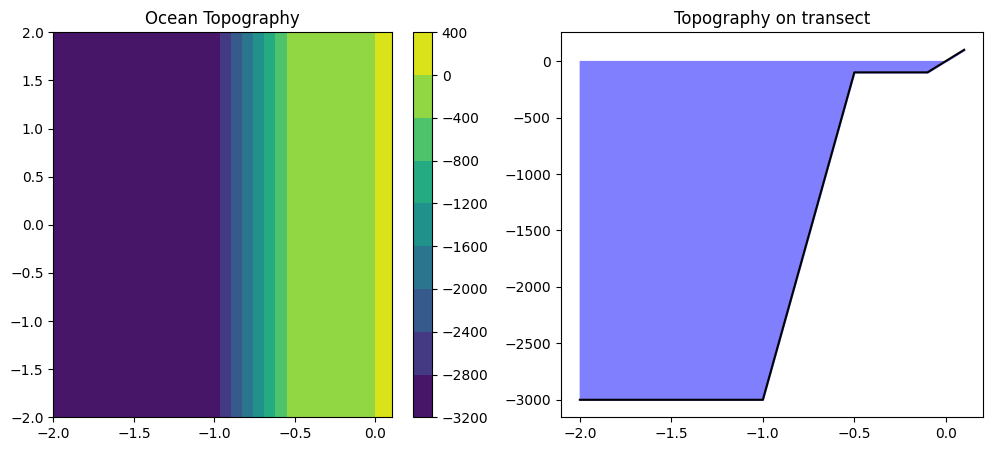

In [8]:
figure(figsize=(12,5))
subplot(121)
contourf(Xo,Yo,Zo)
colorbar()
title('Ocean Topography')
subplot(122)
plot(xo,zo,'k-')
fill_between(xo,zo,maximum(zo,0),color=[.5,.5,1])
title('Topography on transect');

### Save as a topofile:

In [9]:
topo = topotools.Topography()
topo.set_xyZ(xo,yo,Zo)

topofile = '%s/topo_ocean.tt3' % inputdir
topo.write(topofile, topo_type=3, Z_format="%11.3e")
print('Created ', topofile)

Created  input_files/topo_ocean.tt3


<div id="topo_coast"></div>

## Define topo for small coastal region

We define some more complicated topography on a finer grid over a small coastal region with 1/3 arcsecond resolution, chosen to be aligned with integer multiples of degrees (e.g. a grid point at longitude `x=0` and latitude `y=0`) as typical of real DEMs from NCEI.  This is important when aligning computational grids and fgmax grids (if used) in `setrun.py`.   

We will use a cutoff function so that this fine-scale topo matches the linear beach profile of the ocean topography along the edges of this rectangle.  The cutoff is 1 in the center of the rectangle and decays to 0 at the edges:

In [10]:
# choose DEM grid points:
arcsec13 = 1./(3*3600.)  # 1/3 arcsecond
print('arcsec13 = %.6f degrees = %.2f meters' % (arcsec13,arcsec13*111e3))
x = arange(-100*arcsec13, 150*arcsec13, arcsec13)
y = arange(-55*arcsec13, 55*arcsec13, arcsec13)
X,Y = meshgrid(x,y)
print('X.shape = ', X.shape)

x1,x2 = x.min(), x.max()
y1,y2 = y.min(), y.max()
print('Extent of coastal topo: (%.6f, %.6f, %.6f, %.6f)' % (x1,x2,y1,y2))

# define the cutoff function:

w = 0.001 # width of cutoff layer
cutoff = 1. / (1. + exp(1e4*(X-(x2-w))) + exp(1e4*((x1+w)-X)) \
                  + exp(1e4*(Y-(y2-w))) + exp(1e4*((y1+w)-Y)))

arcsec13 = 0.000093 degrees = 10.28 meters
X.shape =  (110, 250)
Extent of coastal topo: (-0.009259, 0.013796, -0.005093, 0.005000)


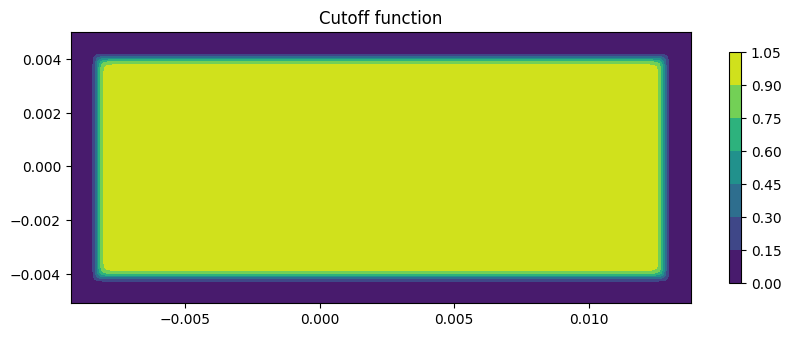

In [11]:
figure(figsize=(10,6))
contourf(X,Y,cutoff)
colorbar(shrink=0.5)
gca().set_aspect(1)
title('Cutoff function');

The topography in this region is the linearly sloping beach augmented by a Gaussian dip.  The beach slope is chosen to agree with the ocean topography offshore (1 km / degree, about 1/100), while onshore there is a smaller slope in this region for illustration.

In [12]:
Z0 = 1e3*X  # sloping beach matching ocean topography
Z1 = where(X<0, 1e3*X, 0.2e3*X)  # smaller slope on shore
R1 = (X-0.004)**2 + (Y-0.002)**2
Z1 += -4*exp(-500000*R1)         # Gaussian dip
Z = (1-cutoff)*Z0 + cutoff*Z1

### Plot the coastal topography:

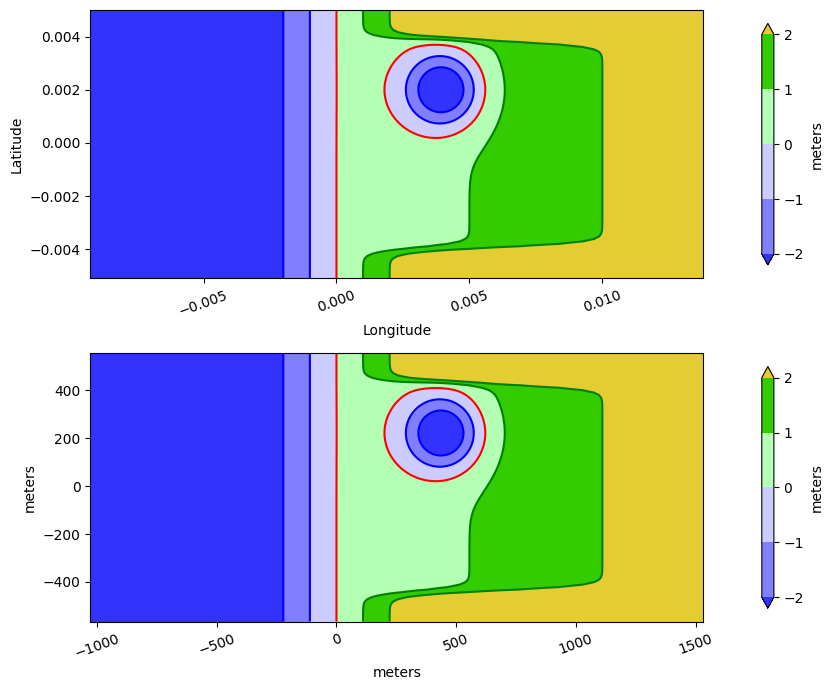

In [13]:
# colors:
c = [[.2,.2,1],[.5,.5,1],[.8,.8,1],[.7,1,.7],[.2,.8,0],[.9,.8,.2]]

figure(figsize=(12,7))
subplot(211)
contourf(X,Y,Z,[-2,-1,0,1,2],colors=c,extend='both')
cb = colorbar(shrink=0.9)
cb.set_label('meters')
contour(X,Y,Z,[-2,-1,0,1,2],colors=['b','b','r','g','g'])
gca().set_aspect(1.)
xticks(rotation=20)
xlabel('Longitude')
ylabel('Latitude')

subplot(212)
contourf(X*111e3,Y*111e3,Z,[-2,-1,0,1,2],colors=c,extend='both')
cb = colorbar(shrink=0.9)
cb.set_label('meters')
contour(X*111e3,Y*111e3,Z,[-2,-1,0,1,2],colors=['b','b','r','g','g'])
gca().set_aspect(1.)
xticks(rotation=20)
xlabel('meters')
ylabel('meters')

tight_layout();

The lower plot in the figure above shows the same topography as on the top, but with x,y units of meters to better show the scale.  Recall that 1 degree is about 111 km and 1/3 arcsec is about 10 meters.

In the plots above, the red contour is at $Z = 0$, and hence is the "shoreline".  However, the isolated "lake" with elevation $Z < 0$ could be dry land below sea level.  Normally with GeoClaw this region would be filled with water initially up to $Z = 0$ everywhere.  Below in [the Force_Dry section](#force_dry), we discuss how to force this region to be initialized as dry if it is in fact dry land.

### Save this as a topofile:

In [14]:
topo = topotools.Topography()
topo.set_xyZ(x,y,Z)

topofile = '%s/topo_shore.tt3' % inputdir
topo.write(topofile, topo_type=3, Z_format="%11.3e")
print('Created ', topofile)

Created  input_files/topo_shore.tt3


### Plot both topo sets together

The coastal region above is very small compared to the ocean region defined above.  Here we plot both together:

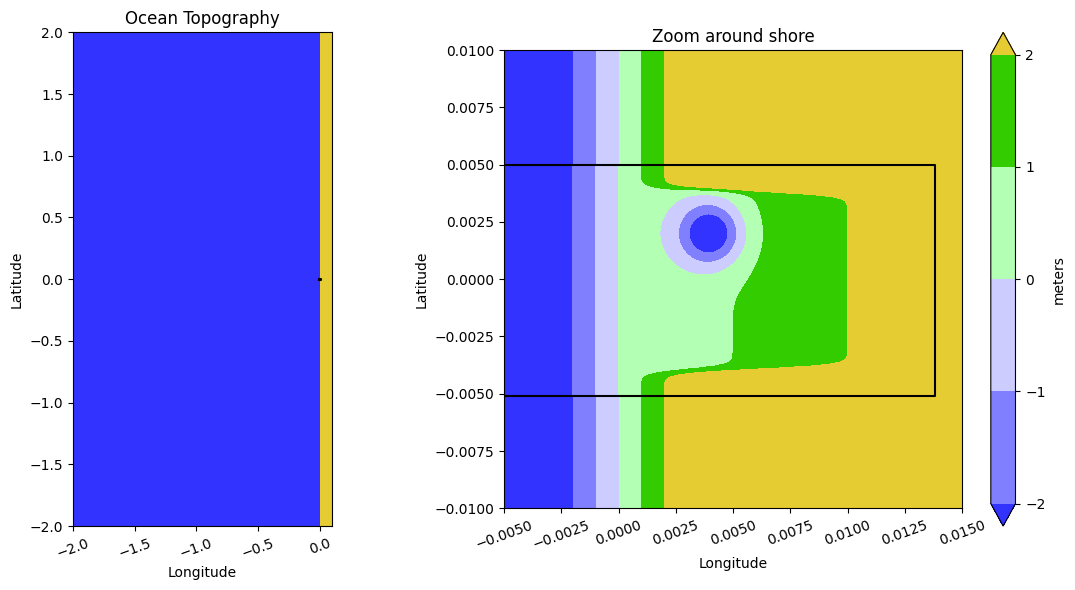

In [15]:
def plot_topo(add_colorbar=False):
    contourf(Xo,Yo,Zo,[-2,-1,0,1,2],colors=c,extend='both')
    contourf(X,Y,Z,[-2,-1,0,1,2],colors=c,extend='both')
    if add_colorbar:
        cb = colorbar()
        cb.set_label('meters')
    #contour(X,Y,Z,[-2,-1,0,1,2],colors=['b','b','r','g','g'])
    plot([x1,x1,x2,x2,x1],[y1,y2,y2,y1,y1],'k')
    gca().set_aspect(1.)
    xticks(rotation=20)
    xlabel('Longitude')
    ylabel('Latitude')

figure(figsize=(12,6))
subplot(121)
plot_topo()
title('Ocean Topography')
subplot(122)
plot_topo(add_colorbar=True)
axis([-0.005, 0.015, -0.01, 0.01])
title('Zoom around shore')
tight_layout()

In the plot on the left above, the black rectangle showing the extent of the coastal DEM is barely visible.  Zooming in shows that the topography does match up near the edges of this rectangle.  In GeoClaw the finest available topography is used when computing cell-averaged topo values, so the coastal DEM will be used for any cell that overlaps this region.

<div id="dtopo"></div>

## Create dtopo for an earthquake source:

We define a simple earthquake in which there is uniform slip on a single subfault. The parameters are chosen to be somewhat reasonable for a subduction zone event offshore, but the shape is a bit odd (width 100 km and length 50 km) in order to give a smallish event with the desired onshore subsidence, for illustration purposes.

In [16]:
subfault = dtopotools.SubFault()
subfault.strike = 0.
subfault.length = 50.e3
subfault.width = 100.e3
subfault.depth = 10.e3
subfault.slip = 5.
subfault.rake = 90.
subfault.dip = 10.
subfault.longitude = -1.
subfault.latitude = 0.
subfault.coordinate_specification = "top center"

fault = dtopotools.Fault()
fault.subfaults = [subfault]

print("Earthquake magnitude: Mw = %.2f" % fault.Mw())
dtopo_fname = '%s/dtopo_test.tt3' % inputdir
print("Using Okada model to create dtopo file", dtopo_fname)

x_deform = linspace(-2, 1, 100)
y_deform = linspace(-1, 1, 100)
times = [1.]

fault.create_dtopography(x_deform,y_deform,times)
dtopo = fault.dtopo

dtopo.write(dtopo_fname, dtopo_type=3)

Earthquake magnitude: Mw = 7.97
Using Okada model to create dtopo file input_files/dtopo_test.tt3


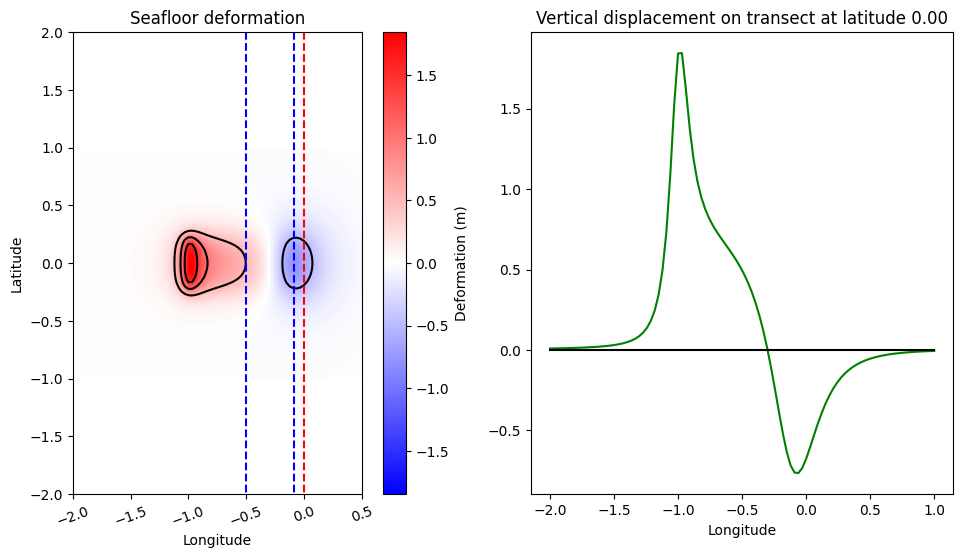

In [17]:
figure(figsize=(12,6))
ax = subplot(121)
dtopo.plot_dZ_colors(2.,axes=ax,dZ_interval=0.5)
contour(Xo,Yo,Zo,[-110,-90,0],colors=['b','b','r'],linestyles='--')
ax.set_aspect(1.)
axis([-2,0.5,-2,2])
xlabel('Longitude')
ylabel('Latitude')

ax = subplot(122)
ylat = 0.
jlat = where(dtopo.y<=ylat)[0].max()
plot(dtopo.x, dtopo.dZ[0,jlat,:],'g')
plot(dtopo.x, 0*dtopo.x, 'k')
xlabel('Longitude')
title('Vertical displacement on transect at latitude %.2f' % ylat);

The left plot above shows the sea floor deformation as contours and colors, along with the extent of the continental shelf as blue dashed lines and the shoreline as a red dashed line. The plot on the right shows the vertical deformation along a transect at latitude 0 going through the coastal region of interest.  

We can compute the subsidence at the location on the shoreline where our fine scale topography is defined as:

In [18]:
xlon = 0.
ilon = where(dtopo.x<=xlon)[0].max()
ylat = 0.
jlat = where(dtopo.y<=ylat)[0].max()
#print(ilon,jlat)
dz0 = dtopo.dZ[0,jlat,ilon]
print('Surface deformation at x=%.2f, y=%.2f is dz = %.2f meters' \
      % (xlon,ylat,dz0))

Surface deformation at x=0.00, y=0.00 is dz = -0.68 meters


This subsidence is enough to significantly change the shoreline location, as seen below:

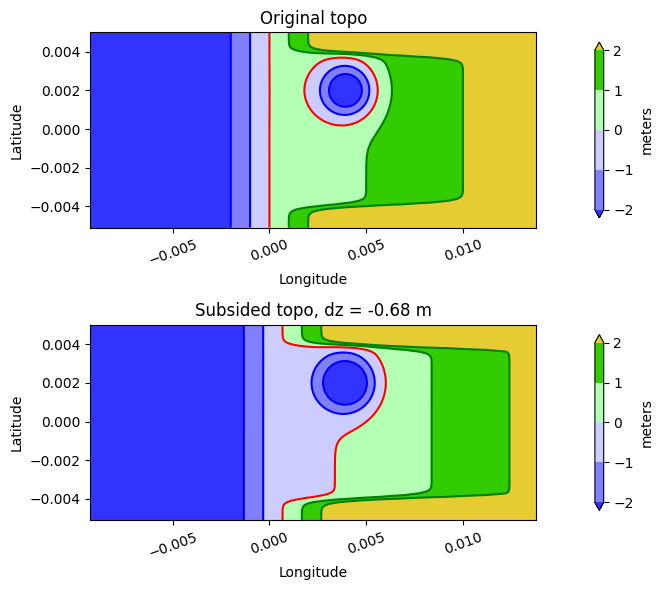

In [19]:
figure(figsize=(12,6))
subplot(211)
contourf(X,Y,Z,[-2,-1,0,1,2],colors=c,extend='both')
cb = colorbar(shrink=0.9)
cb.set_label('meters')
contour(X,Y,Z,[-2,-1,0,1,2],colors=['b','b','r','g','g'])
gca().set_aspect(1.)
xticks(rotation=20)
#xlim(-0.002,0.008)
xlabel('Longitude')
ylabel('Latitude')
title('Original topo')

subplot(212)
Z_postquake = Z + dz0
contourf(X,Y,Z_postquake,[-2,-1,0,1,2],colors=c,extend='both')
cb = colorbar(shrink=0.9)
cb.set_label('meters')
contour(X,Y,Z_postquake,[-2,-1,0,1,2],colors=['b','b','r','g','g'])
gca().set_aspect(1.)
xticks(rotation=20)
#xlim(-0.002,0.008)
xlabel('Longitude')
ylabel('Latitude')
title('Subsided topo, dz = %.2f m' % dz0);

tight_layout()

savefig('topo_with_dz.png')  # save this figure to show in run_geoclaw.ipynb

<div id="force_dry"></div>

# Force Dry array

Now suppose that the onshore lake shown in the plots above is really a depression that should be dry land in spite of being below sea level.  We can use the marching front algorithm from [`clawpack.geoclaw.marching_front`](http://depts.washington.edu/clawpack/sampledocs/dev_v5.7.0/marching_front.html) to identify points that are below sea level but disconnected from the coast.  

We use the marching front algorithm starting by assuming any point with `Z < Z1 = -5` meters should be wet and marching to find all connected points with elevation up to `Z = Z2 = 0`:

In [20]:
wet_points = marching_front.select_by_flooding(topo.Z, Z1=-5., Z2=0., max_iters=None)

Selecting points with Z1 = -5, Z2 = 0, max_iters=27500
Done after 55 iterations with 11110 points chosen


See the documentation page [Force Cells to be Dry Initially](http://depts.washington.edu/clawpack/sampledocs/dev_v5.7.0/force_dry.html) for more discussion of the cells below...

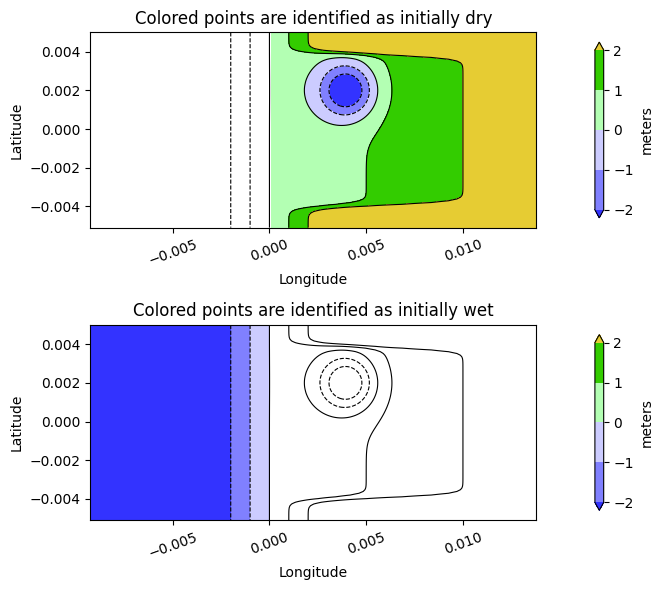

In [21]:
Zdry = ma.masked_array(topo.Z, wet_points)
Zwet = ma.masked_array(topo.Z, logical_not(wet_points))

figure(figsize=(12,6))
subplot(211)
contourf(X,Y,Zdry,[-2,-1,0,1,2],colors=c,extend='both')
cb = colorbar(shrink=0.9)
cb.set_label('meters')
contour(X,Y,Z,[-2,-1,0,1,2],colors='k',linewidths=0.8)
gca().set_aspect(1.)
xticks(rotation=20)
#xlim(-0.002,0.008)
xlabel('Longitude')
ylabel('Latitude')
title('Colored points are identified as initially dry');

subplot(212)
contourf(X,Y,Zwet,[-2,-1,0,1,2],colors=c,extend='both')
cb = colorbar(shrink=0.9)
cb.set_label('meters')
contour(X,Y,Z,[-2,-1,0,1,2],colors='k',linewidths=0.8)
gca().set_aspect(1.)
xticks(rotation=20)
#xlim(-0.002,0.008)
xlabel('Longitude')
ylabel('Latitude')
title('Colored points are identified as initially wet');
tight_layout();

## Create `force_dry_init` array for GeoClaw

First we buffer the points identified above as discussed in the the documentation page [Force Cells to be Dry Initially](http://depts.washington.edu/clawpack/sampledocs/dev_v5.7.0/force_dry.html).

In [22]:
dry_points = 1 - wet_points
dry_points_sum = dry_points[1:-1,1:-1] + dry_points[0:-2,1:-1] + dry_points[2:,1:-1] + \
                 dry_points[1:-1,0:-2] + dry_points[0:-2,0:-2] + dry_points[2:,0:-2] + \
                 dry_points[1:-1,2:] + dry_points[0:-2,2:] + dry_points[2:,2:]

# initialize array to 0 everywhere:
force_dry_init = zeros(dry_points.shape)

# reset in interior to 1 if all points in the 3x3 block around it are dry:
force_dry_init[1:-1,1:-1] = where(dry_points_sum == 9, 1, 0)

And finally create the input file needed for GeoClaw.  Note that this creates a file with the same format as a topofile having `topo_type == 3` as described in [Topography Data documentation](http://www.clawpack.org/topo.html).  We specify `Z_format= '%1i'` to print out single-digit integers since this file has values 0 or 1 rather than topography elevations (with 1 indicated points that should be forced to be dry when initializing grid patches in GeoClaw).

In [23]:
force_dry_init_topo = topotools.Topography()
force_dry_init_topo.set_xyZ(topo.x,topo.y,force_dry_init)

fname_force_dry_init = '%s/force_dry_init.tt3' % inputdir
force_dry_init_topo.write(fname_force_dry_init, topo_type=3, Z_format='%1i')
print('Created %s' % fname_force_dry_init)

Created input_files/force_dry_init.tt3


See [run_geoclaw.ipynb](run_geoclaw.ipynb) for more discussion and sample GeoClaw results.